In [25]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV
import warnings
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.express as px

In [26]:
# Global seeds for reproducibility
np.random.seed(42)
random.seed(42)

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [27]:
### Getting Path of current file
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/swethagayatrikandikonda/Downloads/Projects/SET PROJECT/Amazon-Product-Recommendation-System


In [28]:
# Parse the current folder
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

# Reading the gzip file
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

def get_secondary_cat(arr):
  #text = eval(text)
  if(len(arr) > 1):
    return arr[1]
  else:
    return np.nan

In [29]:
# ------------------------------
# 1. Data Loading and Preprocessing
# ------------------------------

def load_and_preprocess_data():
    """
    Loads product and review data, performs initial cleaning,
    and filters for common ASINs.
    """
    try:
        products_df = pd.read_csv(f'{path}/data/products_with_summary.csv')
        reviews_df = pd.read_csv(f"{path}/data/filtered_reviews_data.csv")

        products_df['asin'] = products_df['asin'].astype(str).str.strip()
        reviews_df['asin'] = reviews_df['asin'].astype(str).str.strip()

        # Remove duplicate reviews (reviewerID, asin, rating combination)
        reviews_df = reviews_df.drop_duplicates(subset=['reviewerID', 'asin', 'rating']).copy()
        # Drop rows with missing essential identifiers or ratings
        reviews_df = reviews_df.dropna(subset=['asin', 'rating', 'reviewerID'])
        products_df = products_df.dropna(subset=['asin', 'title'])

        # Keep only ASINs common to both dataframes
        common_asins = set(reviews_df['asin']).intersection(set(products_df['asin']))
        reviews_df = reviews_df[reviews_df['asin'].isin(common_asins)]
        products_df = products_df[products_df['asin'].isin(common_asins)]

        print(f"Data loaded successfully:")
        print(f"   - Reviews: {len(reviews_df):,}")
        print(f"   - Products: {len(products_df):,}")
        print(f"   - Common ASINs: {len(common_asins):,}")

        return products_df, reviews_df
    except FileNotFoundError:
        print("Error: Make sure 'products_with_summary.csv' and 'filtered_reviews_data.csv' are in the same directory.")
        return None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

In [30]:
def improved_preprocess_text(text):
    """
    Cleans and normalizes text for content-based analysis.
    Converts to lowercase, removes most special characters (keeps hyphens, colons, periods),
    and handles multiple spaces.
    """
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Keep alphanumeric characters, spaces, hyphens, colons, and periods.
    text = re.sub(r'[^\w\s\-\:\.]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [31]:
def prepare_products_data(products_df):
    """
    Prepares product data for content-based modeling.
    Fills missing summaries, combines relevant text fields, and preprocesses the combined text.
    """
    products_df = products_df.copy()
    # Use 'summary' if available, otherwise fall back to 'description'
    products_df['summary'] = products_df['summary'].fillna(products_df['description'].fillna(''))
    # Combine relevant text fields for embedding
    products_df['combined'] = (
        products_df['title'].astype(str) + " " +
        products_df['summary'].astype(str) + " " +
        products_df['brand'].astype(str).fillna('') + " " +
        products_df['secondary_cat'].astype(str).fillna('')
    )
    products_df['combined'] = products_df['combined'].apply(improved_preprocess_text)
    # Filter out products with empty combined text after preprocessing
    products_df = products_df[products_df['combined'].str.len() > 0]
    return products_df

In [32]:
def filter_active_users_products(reviews_df, min_user_reviews=5, min_product_reviews=10):
    """
    Filters reviews to include only active users and popular products,
    improving the density and quality of the collaborative filtering matrix.
    """
    user_counts = reviews_df['reviewerID'].value_counts()
    product_counts = reviews_df['asin'].value_counts()
    
    active_users = user_counts[user_counts >= min_user_reviews].index
    active_products = product_counts[product_counts >= min_product_reviews].index
    
    filtered_df = reviews_df[
        (reviews_df['reviewerID'].isin(active_users)) &
        (reviews_df['asin'].isin(active_products))
    ].copy()
    
    print(f"Filtering results:")
    print(f"   - Active users (≥{min_user_reviews} reviews): {len(active_users):,}")
    print(f"   - Active products (≥{min_product_reviews} reviews): {len(active_products):,}")
    print(f"   - Filtered reviews: {len(filtered_df):,}")
    
    return filtered_df

In [33]:
# ------------------------------
# 2. Train/Test Split
# ------------------------------

def create_train_test_split(reviews_df, test_size=0.2, random_state=42):
    """
    Splits the review data into training and testing sets.
    Prioritizes temporal split if 'unixReviewTime' is available, otherwise uses random split.
    Ensures that test users have at least some data in the training set.
    """
    if 'unixReviewTime' in reviews_df.columns:
        reviews_df_sorted = reviews_df.sort_values('unixReviewTime')
        split_idx = int(len(reviews_df_sorted) * (1 - test_size))
        train_df = reviews_df_sorted.iloc[:split_idx].copy()
        test_df = reviews_df_sorted.iloc[split_idx:].copy()
        print("Using temporal split")
    else:
        train_df = reviews_df.sample(frac=1-test_size, random_state=random_state)
        test_df = reviews_df.drop(train_df.index)
        print("Using random split")
    
    # Ensure all users in the test set have at least one rating in the training set
    # This is crucial for evaluating collaborative filtering for these users.
    train_users = set(train_df['reviewerID'])
    test_df = test_df[test_df['reviewerID'].isin(train_users)]
    
    print(f"   - Training reviews: {len(train_df):,}")
    print(f"   - Test reviews: {len(test_df):,}")
    print(f"   - Test users with training data: {test_df['reviewerID'].nunique():,}")
    
    return train_df, test_df

In [34]:
# ------------------------------
# 3. Content-Based Model
# ------------------------------

def build_content_model(products_df):
    """
    Builds the content-based model by generating sentence embeddings for products.
    """
    try:
        print("Building content-based model...")
        # Using a pre-trained Sentence Transformer model for embeddings
        model = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = model.encode(products_df['combined'].tolist(), show_progress_bar=True)
        # Create a mapping from ASIN to its index in the embeddings array
        asin_to_idx = {asin: idx for idx, asin in enumerate(products_df['asin'])}
        print("Content-based model built successfully")
        return embeddings, asin_to_idx, model
    except Exception as e:
        print(f"Error building content model: {e}")
        return None, None, None

In [35]:
def get_content_similarity(asin1, asin2, embeddings, asin_to_idx):
    """
    Calculates cosine similarity between two product ASINs using their embeddings.
    Returns 0.0 if either ASIN is not found.
    """
    try:
        idx1 = asin_to_idx.get(asin1)
        idx2 = asin_to_idx.get(asin2)
        if idx1 is None or idx2 is None:
            return 0.0
        # Reshape embeddings for cosine_similarity function
        return cosine_similarity(embeddings[idx1].reshape(1, -1), embeddings[idx2].reshape(1, -1))[0][0]
    except Exception:
        # Catch any other potential errors during similarity calculation
        return 0.0

In [ ]:
# ------------------------------
# 4. Collaborative Filtering Model
# ------------------------------

def build_collaborative_model(train_df):
    """
    Builds and tunes the SVD collaborative filtering model using GridSearchCV.
    """
    try:
        print("Starting collaborative filtering model tuning (SVD)...")
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(train_df[['reviewerID', 'asin', 'rating']], reader)

        # Define parameter grid for GridSearchCV
        param_grid = {
            'n_factors': [50, 80, 100],  # Number of latent factors
            'n_epochs': [20, 30, 40],   # Number of epochs for stochastic gradient descent
            'lr_all': [0.005, 0.007, 0.01], # Learning rate for all parameters
            'reg_all': [0.02, 0.05, 0.1]    # Regularization term for all parameters
        }
        
        # GridSearchCV for hyperparameter optimization
        gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose=1)
        gs.fit(data)

        print("Best RMSE:", gs.best_score['rmse'])
        print("Best MAE:", gs.best_score['mae'])
        print("Best params:", gs.best_params['rmse'])

        # Train the SVD model with the best parameters on the full training set
        best_algo = SVD(**gs.best_params['rmse'], random_state=42)
        full_trainset = data.build_full_trainset()
        best_algo.fit(full_trainset)
        print("Collaborative filtering model built successfully.")
        return best_algo
    except Exception as e:
        print(f"Error building collaborative model: {e}")
        return None

In [37]:
# ------------------------------
# 5. Scoring Functions
# ------------------------------

def get_collaborative_scores(user_id, product_ids, algo):
    """
    Retrieves predicted ratings from the collaborative filtering model for given products.
    """
    scores = {}
    for pid in product_ids:
        # algo.predict returns a Prediction object; .est is the estimated rating
        scores[pid] = algo.predict(user_id, pid).est
    return scores

In [38]:
def get_improved_content_scores(user_id, product_ids, train_df, embeddings, asin_to_idx, liked_threshold=3.5, disliked_threshold=2.0):
    """
    Calculates content-based scores incorporating both liked and disliked items.
    Items rated >= liked_threshold are considered liked.
    Items rated <= disliked_threshold are considered disliked.
    """
    user_ratings = train_df[train_df['reviewerID'] == user_id]
    
    if user_ratings.empty:
        # If the user has no ratings, content-based scores are zero
        return {pid: 0.0 for pid in product_ids}

    scores = {}
    for candidate_pid in product_ids:
        weighted_contribution_sum = 0.0
        total_absolute_weight = 0.0

        for _, row in user_ratings.iterrows():
            rated_asin = row['asin']
            rating = row['rating']

            sim = get_content_similarity(candidate_pid, rated_asin, embeddings, asin_to_idx)

            if rating >= liked_threshold:
                # Positive weight for liked items: higher rating means more influence
                # Scale rating from threshold to 5 (e.g., 3.5->1, 4->1.5, 5->2.5)
                weight = (rating - liked_threshold + 1.0) 
                weighted_contribution_sum += sim * weight
                total_absolute_weight += weight
            elif rating <= disliked_threshold:
                # Negative weight for disliked items: similarity to disliked item is penalized
                # Scale rating from 1 to disliked_threshold (e.g., 1->2, 2->1)
                weight = (disliked_threshold - rating + 1.0) 
                weighted_contribution_sum += sim * (-weight) # Penalize items similar to disliked ones
                total_absolute_weight += weight # Still add absolute weight to denominator for proper averaging
            # Ratings between disliked_threshold and liked_threshold are considered neutral and ignored by default

        scores[candidate_pid] = weighted_contribution_sum / total_absolute_weight if total_absolute_weight > 0 else 0.0
    return scores

In [39]:
def robust_normalize_scores(scores):
    """
    Normalizes a dictionary of scores to a 0-1 range.
    Handles cases where all scores are identical to prevent division by zero.
    """
    if not scores:
        return {}
    
    values = np.array(list(scores.values()))
    min_s, max_s = values.min(), values.max()

    if max_s == min_s:
        # If all scores are the same, normalize to 0 if all are 0, else 1
        return {k: (1.0 if v != 0 else 0.0) for k, v in scores.items()}
    else:
        # Min-max normalization
        return {k: (v - min_s) / (max_s - min_s) for k, v in scores.items()}

In [40]:
# ------------------------------
# 6. Hybrid Recommendation System
# ------------------------------

def hybrid_recommendations(user_id, products_df, train_df, embeddings, asin_to_idx, algo, top_n=10, min_ratings_for_cf=5, num_candidates=2000):
    """
    Generates hybrid recommendations for a user, combining CF and Content-Based scores.
    Dynamically adjusts the weighting (alpha) based on user's rating history.
    Includes a popularity boost and smarter candidate generation.
    """
    user_ratings = train_df[train_df['reviewerID'] == user_id]
    num_ratings = len(user_ratings)

    if num_ratings == 0:
        return pd.DataFrame()

    # Dynamic alpha: more ratings -> more collaborative filtering influence
    if num_ratings < min_ratings_for_cf:
        alpha = 0.1 # Mostly content-based for very new users
    elif num_ratings < 20:
        alpha = 0.4 # Balanced
    else:
        alpha = 0.7 # Leaning towards collaborative for experienced users

    rated_products = set(user_ratings['asin'])
    all_unrated_products = [p for p in products_df['asin'] if p not in rated_products]

    if not all_unrated_products:
        return pd.DataFrame()

    # --- Smarter Candidate Generation ---
    candidate_products = set()

    # 1. Candidates from items similar to user's liked items (Content-Based)
    liked_items = user_ratings[user_ratings['rating'] >= 3.5]['asin'].tolist()
    if liked_items:
        # Consider top 5 liked items for content-based candidate generation
        for liked_asin in liked_items[:5]: 
            liked_idx = asin_to_idx.get(liked_asin)
            if liked_idx is not None:
                liked_embedding = embeddings[liked_idx]
                # Calculate similarity with all unrated products
                similarities = {}
                for unrated_asin in all_unrated_products:
                    unrated_idx = asin_to_idx.get(unrated_asin)
                    if unrated_idx is not None:
                        sim = cosine_similarity(liked_embedding.reshape(1, -1), embeddings[unrated_idx].reshape(1, -1))[0][0]
                        similarities[unrated_asin] = sim
                
                # Add top N most similar unrated products
                top_similar_unrated = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:50] # Top 50 similar
                candidate_products.update([asin for asin, _ in top_similar_unrated])

    # 2. Candidates from popular items (general fallback)
    item_popularity = train_df['asin'].value_counts()
    top_popular_items = item_popularity.head(200).index.tolist() # Top 200 popular items
    candidate_products.update(top_popular_items)
    
    # Convert to list and ensure it doesn't exceed num_candidates
    candidate_products = list(candidate_products.intersection(set(all_unrated_products))) # Ensure they are unrated
    if len(candidate_products) > num_candidates:
        candidate_products = random.sample(candidate_products, num_candidates)
    elif len(candidate_products) < num_candidates and len(all_unrated_products) > len(candidate_products):
        # If not enough candidates from smart generation, fill with random unrated
        remaining_candidates = list(set(all_unrated_products) - set(candidate_products))
        num_to_add = num_candidates - len(candidate_products)
        candidate_products.extend(random.sample(remaining_candidates, min(num_to_add, len(remaining_candidates))))

    if not candidate_products: # Check again after candidate generation
        return pd.DataFrame()

    # Get content-based scores
    content_scores = get_improved_content_scores(user_id, candidate_products, train_df, embeddings, asin_to_idx)
    content_scores_norm = robust_normalize_scores(content_scores)

    hybrid_scores = {}

    # Only incorporate CF if the user has enough ratings and CF model is available
    if num_ratings >= min_ratings_for_cf and algo is not None:
        cf_scores = get_collaborative_scores(user_id, candidate_products, algo)
        cf_scores_norm = robust_normalize_scores(cf_scores)

        for pid in candidate_products:
            # Combine normalized scores
            cf_score = cf_scores_norm.get(pid, 0.0)
            content_score = content_scores_norm.get(pid, 0.0)
            hybrid_scores[pid] = alpha * cf_score + (1 - alpha) * content_score
    else:
        # Fallback to pure content-based if CF cannot be used
        hybrid_scores = content_scores_norm

    # Popularity boost: give a slight advantage to popular items
    item_popularity = train_df['asin'].value_counts()
    for pid in hybrid_scores:
        # Add a logarithmic boost; log1p handles count of 0 or 1 gracefully
        hybrid_scores[pid] += 0.01 * np.log1p(item_popularity.get(pid, 0)) 

    # Sort candidates by hybrid score and select top N
    top_recommendations = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Create DataFrame for results, joining with product details
    recommended_asins = [x[0] for x in top_recommendations]
    results = products_df[products_df['asin'].isin(recommended_asins)].copy()
    
    # Map hybrid scores back to the DataFrame and sort
    score_map = dict(top_recommendations)
    results['hybrid_score'] = results['asin'].map(score_map)
    results = results.sort_values('hybrid_score', ascending=False).reset_index(drop=True)
    return results

In [41]:
# ------------------------------
# 7. Evaluation
# ------------------------------

def calculate_ndcg(recommended_items, relevant_items, k):
    """
    Calculates Normalized Discounted Cumulative Gain (NDCG@K).
    """
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1 / np.log2(i + 2)
    
    ideal_dcg = 0.0
    for i in range(min(len(relevant_items), k)):
        ideal_dcg += 1 / np.log2(i + 2)
    
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

In [42]:
def evaluate_recommendations(user_id, train_df, test_df, products_df, embeddings, asin_to_idx, algo, top_k=10, eval_liked_threshold=3.5):
    """
    Evaluates recommendations for a single user.
    """
    recs_df = hybrid_recommendations(user_id, products_df, train_df, embeddings, asin_to_idx, algo, top_n=top_k)
    
    if recs_df.empty:
        return 0, 0, 0, 0

    recommended_items_list = recs_df['asin'].tolist()
    user_test_data = test_df[test_df['reviewerID'] == user_id]
    liked_items_in_test = set(user_test_data[user_test_data['rating'] >= eval_liked_threshold]['asin'])

    if not liked_items_in_test:
        return 0, 0, 0, 0

    recommended_at_k = set(recommended_items_list[:top_k])
    true_positives = recommended_at_k.intersection(liked_items_in_test)
    
    precision = len(true_positives) / len(recommended_at_k) if len(recommended_at_k) > 0 else 0
    recall = len(true_positives) / len(liked_items_in_test) if len(liked_items_in_test) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    ndcg = calculate_ndcg(recommended_items_list, liked_items_in_test, top_k)
    
    return precision, recall, f1, ndcg

In [43]:
def comprehensive_evaluation(train_df, test_df, products_df, embeddings, asin_to_idx, algo, sample_size=100, top_k=10, eval_liked_threshold=3.5):
    """
    Performs comprehensive evaluation across a sample of eligible users.
    """
    train_users = set(train_df['reviewerID'])
    test_users = set(test_df['reviewerID'])
    
    eligible_users = [u for u in train_users.intersection(test_users)
                      if len(train_df[train_df['reviewerID'] == u]) >= 10 and
                         len(test_df[test_df['reviewerID'] == u]) >= 2]

    if not eligible_users:
        print("No eligible users found for evaluation after filtering.")
        return None

    sample_size = min(sample_size, len(eligible_users))
    eval_users = random.sample(eligible_users, sample_size)
    print(f"Evaluating {len(eval_users):,} users for comprehensive metrics (K={top_k}, liked_threshold={eval_liked_threshold})...")

    precisions, recalls, f1s, ndcgs = [], [], [], []

    for i, user in enumerate(eval_users):
        if (i + 1) % 20 == 0:
            print(f"  Evaluating user {i+1}/{len(eval_users)}")
            
        p, r, f1, ndcg = evaluate_recommendations(user, train_df, test_df, products_df, embeddings, asin_to_idx, algo, top_k, eval_liked_threshold)
        
        if p > 0 or r > 0 or f1 > 0 or ndcg > 0:
            precisions.append(p)
            recalls.append(r)
            f1s.append(f1)
            ndcgs.append(ndcg)

    if not precisions:
        print("No valid evaluation results for any user.")
        return None

    return {
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'F1@K': np.mean(f1s),
        'NDCG@K': np.mean(ndcgs),
        'Users_Evaluated': len(precisions)
    }

In [44]:
# ------------------------------
# 8. Visualizations
# ------------------------------

def visualize_ratings_distribution(filtered_reviews_df):
    """
    Generates and displays a bar chart of the rating distribution.
    """
    print("\n--- Exploratory Data Analysis: Ratings Distribution ---")
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    ax = sns.countplot(
        x='rating',
        data=filtered_reviews_df,
        palette='viridis',
        order=[1.0, 2.0, 3.0, 4.0, 5.0]
    )

    ax.set_title('Distribution of Ratings in the Filtered Dataset', fontsize=16, fontweight='bold')
    ax.set_xlabel('Rating', fontsize=12)
    ax.set_ylabel('Number of Reviews', fontsize=12)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()):,}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=11, color='black',
                    xytext=(0, 10),
                    textcoords='offset points')
    plt.show()

In [45]:
def visualize_user_activity(filtered_reviews_df):
    """
    Generates and displays a histogram of the number of reviews per user ("Long Tail").
    """
    print("\n--- Exploratory Data Analysis: User Activity (Long Tail) ---")
    user_review_counts = filtered_reviews_df['reviewerID'].value_counts()
    
    plt.figure(figsize=(12, 7))
    sns.histplot(user_review_counts, bins=50, kde=False, color='mediumpurple')

    plt.title('Distribution of Reviews per User (The "Long Tail")', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Reviews Submitted by a Single User', fontsize=12)
    plt.ylabel('Number of Users (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.show()

    print(f"Key Insight: A few 'power users' dominate, while most users have few reviews.")
    print(f"Total Active Users: {len(user_review_counts):,}")
    print(f"Median reviews per user: {user_review_counts.median()}")
    print(f"Max reviews by a single user: {user_review_counts.max()}")

In [46]:
def visualize_evaluation_metrics(evaluation_results):
    """
    Generates and displays a bar chart of the final evaluation metrics.
    """
    if not evaluation_results:
        print("No evaluation results to visualize.")
        return

    print("\n--- Visualization of Final Evaluation Metrics ---")
    
    metrics_to_plot = {k: v for k, v in evaluation_results.items() if k != 'Users_Evaluated'}
    metrics_df = pd.DataFrame(list(metrics_to_plot.items()), columns=['Metric', 'Score'])

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.barplot(x='Metric', y='Score', data=metrics_df, palette='magma')

    ax.set_title('Hybrid Model Evaluation Metrics (Top-10 Recommendations)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Evaluation Metric', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, max(metrics_df['Score']) * 1.2)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=11, color='black',
                    xytext=(0, 10),
                    textcoords='offset points')
    plt.show()

In [47]:
def visualize_user_recommendation_profile(user_id, train_df, recommendations_df, products_df, num_past_items=5):
    """
    Visualizes a user's past liked items and the model's recommendations.
    """
    user_past_ratings = train_df[train_df['reviewerID'] == user_id].sort_values('rating', ascending=False)
    past_liked_asins = user_past_ratings.head(num_past_items)['asin']
    past_liked_titles = products_df[products_df['asin'].isin(past_liked_asins)]['title'].tolist()

    recommended_titles = recommendations_df['title'].tolist()
    recommended_scores = recommendations_df['hybrid_score'].tolist()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})
    fig.suptitle(f'Recommendation Profile for User: {user_id}', fontsize=20, fontweight='bold')

    ax1.set_title("User's Top-Rated Games (Past)", fontsize=16)
    ax1.invert_yaxis()
    ax1.barh(range(len(past_liked_titles)), [1]*len(past_liked_titles), color='skyblue')
    for i, title in enumerate(past_liked_titles):
        ax1.text(0.02, i, f"• {title[:40]}...", va='center', fontsize=12)
    ax1.axis('off')

    ax2.set_title("System's Top Recommendations (New)", fontsize=16)
    ax2.invert_yaxis()
    ax2.barh(range(len(recommended_titles)), [1]*len(recommended_titles), color='lightgreen')
    for i, (title, score) in enumerate(zip(recommended_titles, recommended_scores)):
        ax2.text(0.02, i, f"• {title[:40]}... (Score: {score:.3f})", va='center', fontsize=12)
    ax2.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
 

In [48]:
# ------------------------------
# 9. Main Execution
# ------------------------------

def main():
    """
    Main function to run the complete recommendation system pipeline.
    """
    print("Starting Video Game Recommendation System Pipeline")
    
    # 1. Data Loading and Preprocessing
    products_df, reviews_df = load_and_preprocess_data()
    if products_df is None or reviews_df is None:
        return {} # Exit if data loading fails
    
    products_df = prepare_products_data(products_df)
    
    # Filter for active users and products
    filtered_reviews = filter_active_users_products(reviews_df)
    if len(filtered_reviews) == 0:
        print("Not enough filtered reviews to proceed. Adjust filtering parameters or data.")
        return {}
        
    # --- EDA Visualization Calls ---
    visualize_ratings_distribution(filtered_reviews)
    visualize_user_activity(filtered_reviews)

    # 2. Train/Test Split
    train_df, test_df = create_train_test_split(filtered_reviews)
    if train_df.empty or test_df.empty:
        print("Train or Test DataFrame is empty after split. Check data or split ratio.")
        return {}

    # 3. Build Content-Based Model
    embeddings, asin_to_idx, sentence_model = build_content_model(products_df)
    if embeddings is None:
        return {} # Exit if content model building fails

    # 4. Build Collaborative Filtering Model
    algo = build_collaborative_model(train_df)
    # Note: 'algo' can be None if CF model building fails; hybrid system will adapt.

    print("\n--- Sample Recommendations ---")
    # Get a few active users from the training set for demonstration
    # Select users with at least 15 ratings to see CF and content blending
    sample_users = train_df['reviewerID'].value_counts()
    sample_users = sample_users[sample_users >= 15].head(3).index.tolist()

    if not sample_users:
        print("No users found with sufficient ratings for sample recommendations.")
    else:
        for user in sample_users:
            recs = hybrid_recommendations(user, products_df, train_df, embeddings, asin_to_idx, algo, top_n=5)
            print(f"\nUser {user}:")
            if not recs.empty:
                for idx, row in recs.head(5).iterrows():
                    print(f"  {idx+1}. {row['title']} (Score: {row['hybrid_score']:.3f})")
            else:
                print("  No recommendations found for this user.")
                
    print("\n--- Model Evaluation ---")
    # 7. Comprehensive Evaluation
    # *Crucially, modified eval_liked_threshold here to 3.0 for better coverage.*
    evaluation_results = comprehensive_evaluation(train_df, test_df, products_df, embeddings, asin_to_idx, algo, sample_size=200, top_k=10, eval_liked_threshold=3.0)
    if evaluation_results:
        for k, v in evaluation_results.items():
            if k == 'Users_Evaluated':
                print(f"{k}: {v}")
            else:
                print(f"{k}: {v:.4f} ({v*100:.2f}%)")
        
        # --- Call the new visualization function for evaluation metrics ---
        visualize_evaluation_metrics(evaluation_results)
    else:
        print("Evaluation could not be performed or yielded no results.")

    # Return key components for potential external usage (e.g., in the usage example)
    return {
        'products_df': products_df,
        'reviews_df': reviews_df, # original reviews_df
        'filtered_reviews': filtered_reviews,
        'train_df': train_df,
        'test_df': test_df,
        'embeddings': embeddings,
        'asin_to_idx': asin_to_idx,
        'sentence_model': sentence_model,
        'algo': algo,
        'evaluation_results': evaluation_results
    }

Starting Video Game Recommendation System Pipeline
Data loaded successfully:
   - Reviews: 73,042
   - Products: 1,000
   - Common ASINs: 1,000
Filtering results:
   - Active users (≥5 reviews): 1,717
   - Active products (≥10 reviews): 952
   - Filtered reviews: 14,068

--- Exploratory Data Analysis: Ratings Distribution ---


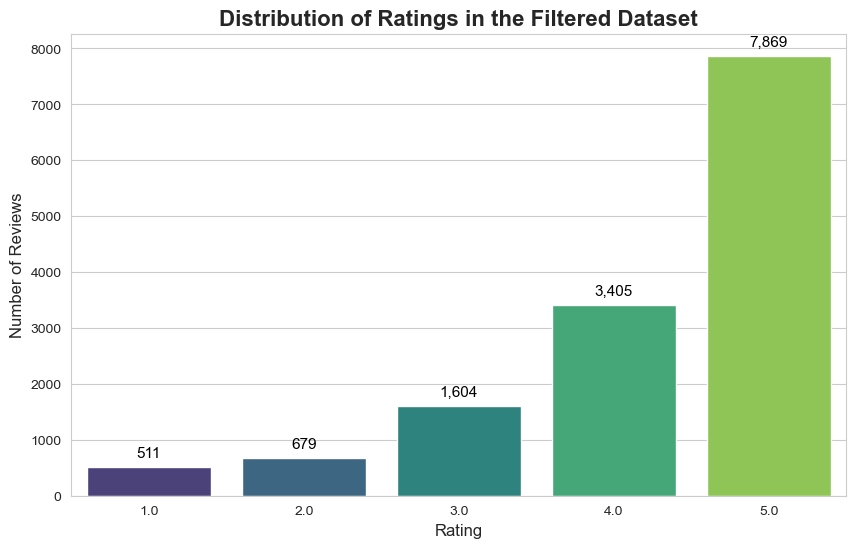


--- Exploratory Data Analysis: User Activity (Long Tail) ---


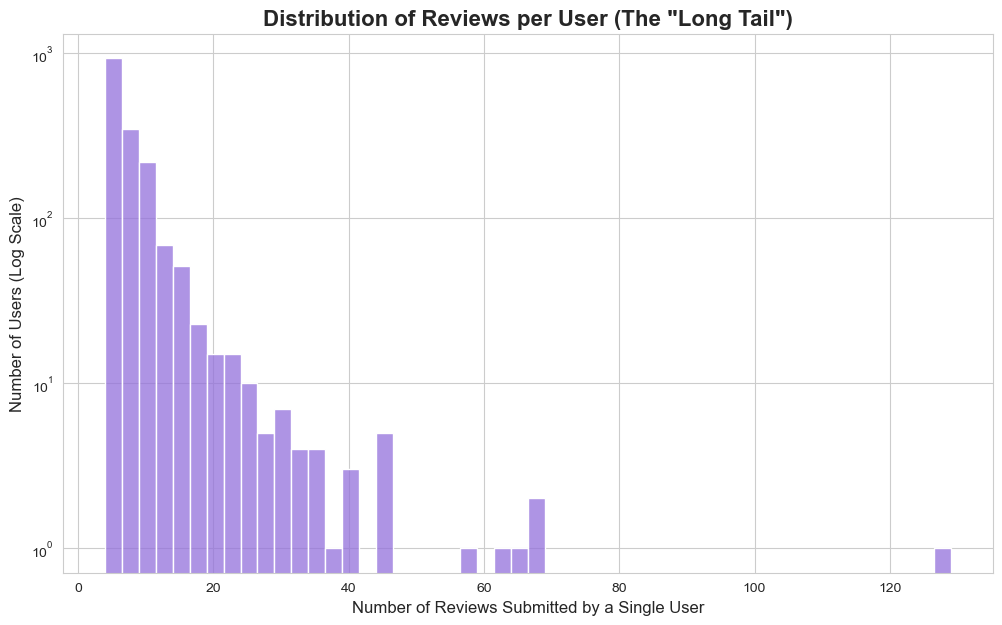

Key Insight: A few 'power users' dominate, while most users have few reviews.
Total Active Users: 1,717
Median reviews per user: 6.0
Max reviews by a single user: 129
Using temporal split
   - Training reviews: 11,254
   - Test reviews: 879
   - Test users with training data: 279
Building content-based model...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Content-based model built successfully
Starting collaborative filtering model tuning (SVD)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 384 out of 405 | elapsed:    5.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    5.8s finished


Best RMSE: 0.9798013132508336
Best MAE: 0.73834155660533
Best params: {'n_factors': 80, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}
Collaborative filtering model built successfully.

--- Sample Recommendations ---

User A3V6Z4RCDGRC44:
  1. Final Fantasy III (Score: 1.013)
  2. Deus Ex - PC (Score: 0.982)
  3. Final Fantasy II (Score: 0.976)
  4. Binary Domain - Playstation 3 (Score: 0.953)
  5. Mortal Kombat II (Score: 0.945)

User AQMWZIH22R6LE:
  1. Super Smash Bros Melee (Score: 1.004)
  2. Final Fantasy VII (Score: 0.998)
  3. Final Fantasy III (Score: 0.997)
  4. Marvel Vs. Capcom 2 (Score: 0.980)
  5. Sonic the Hedgehog 2 (Score: 0.976)

User A3PASG15BRR40D:
  1. Final Fantasy III (Score: 0.948)
  2. Unreal Tournament 2004 (Score: 0.932)
  3. Jak 3 - PlayStation 2 (Score: 0.928)
  4. Marvel Vs. Capcom 2 (Score: 0.908)
  5. Advance Wars (Score: 0.902)

--- Model Evaluation ---
Evaluating 27 users for comprehensive metrics (K=10, liked_threshold=3.0)...
  Evaluating user 20/2

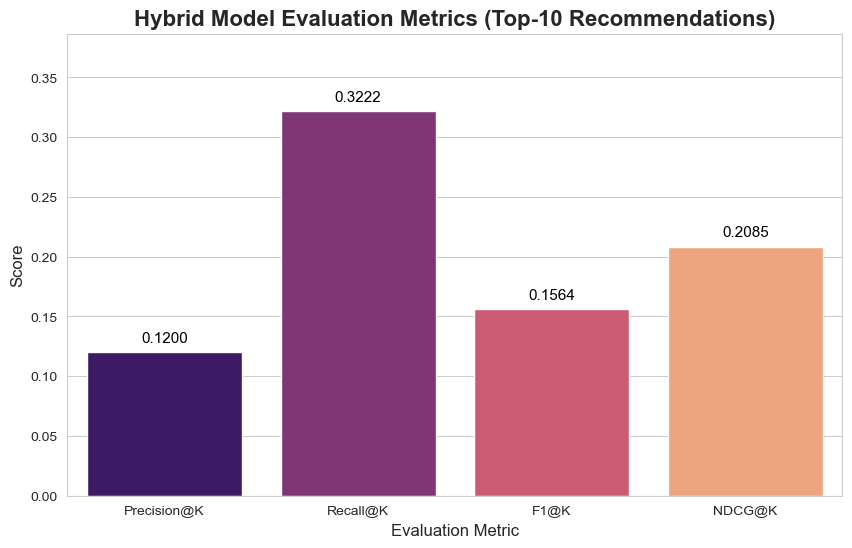


Try Generating Recommendations for a Specific User
Attempting to generate recommendations for a demo user: A1R602SXNGOMJ4

🎯 Top 10 Recommendations for user A1R602SXNGOMJ4:


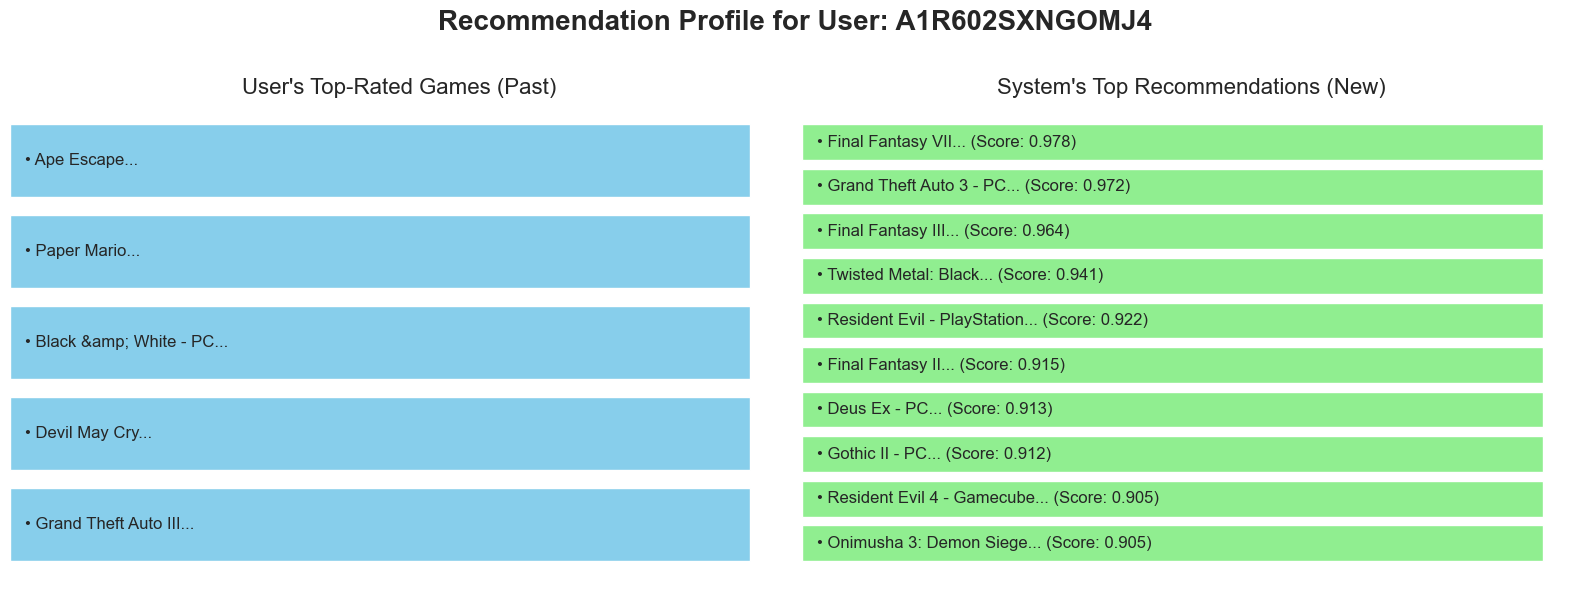

    1. Final Fantasy VII (Score: 0.978)
    2. Grand Theft Auto 3 - PC (Score: 0.972)
    3. Final Fantasy III (Score: 0.964)
    4. Twisted Metal: Black (Score: 0.941)
    5. Resident Evil - PlayStation (Score: 0.922)
    6. Final Fantasy II (Score: 0.915)
    7. Deus Ex - PC (Score: 0.913)
    8. Gothic II - PC (Score: 0.912)
    9. Resident Evil 4 - Gamecube (Score: 0.905)
    10. Onimusha 3: Demon Siege (Score: 0.905)

--- Visualizing Product Semantics with t-SNE ---
Running t-SNE... this may take a minute or two.
t-SNE calculation complete!


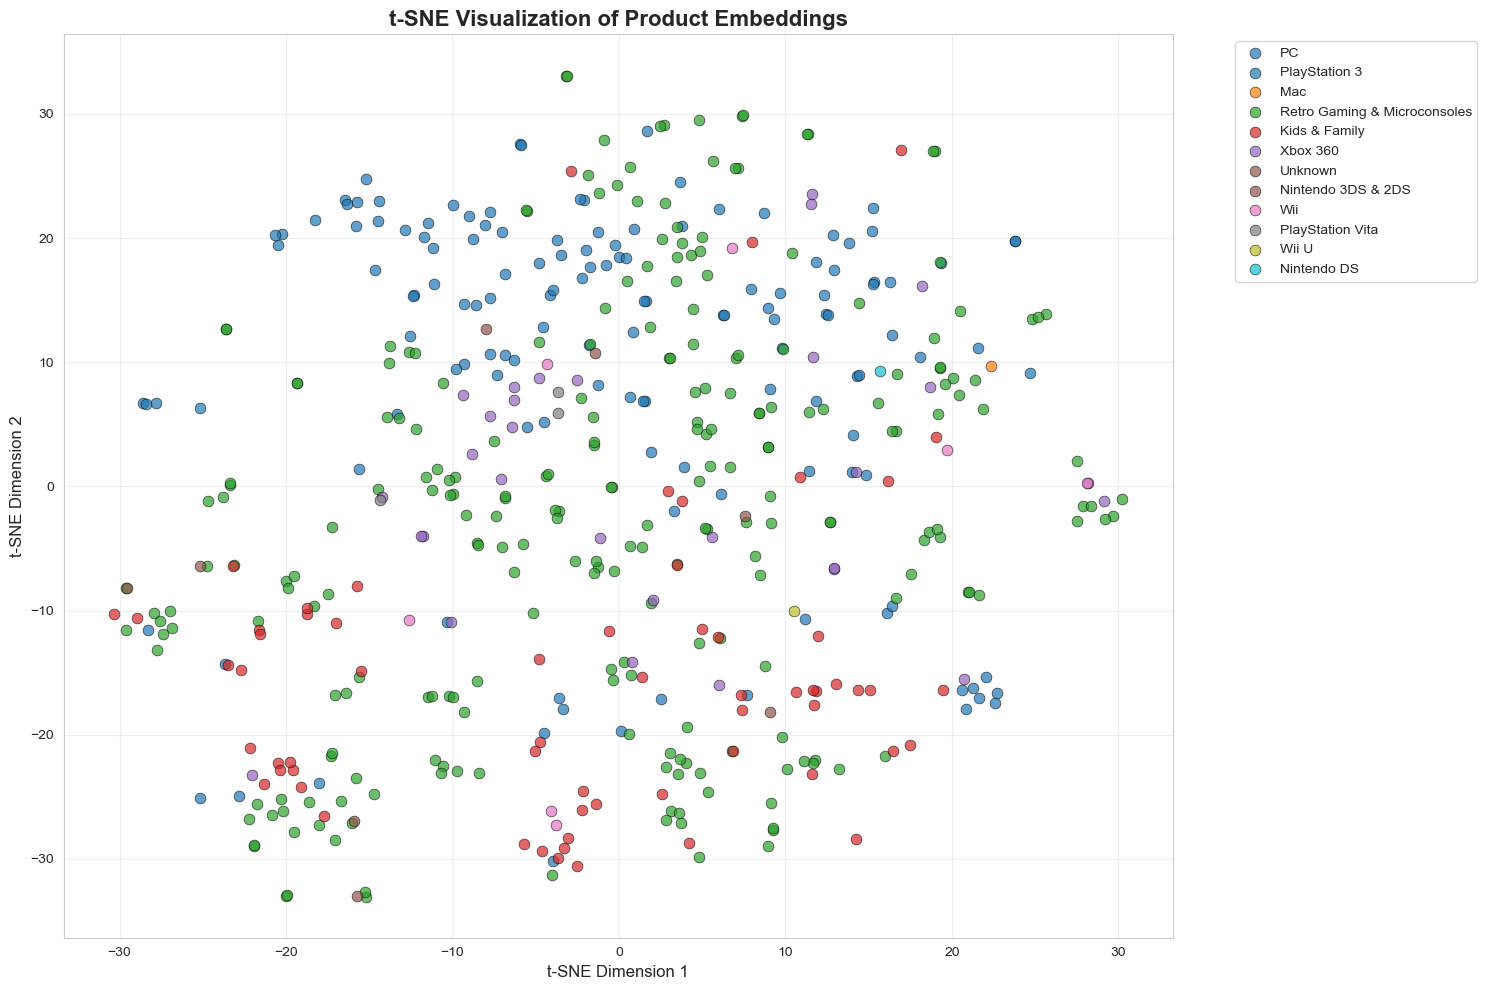

Plotted 500 products across 12 categories


In [49]:
# ------------------------------
# 10. Usage Example
# ------------------------------
if __name__ == "__main__":
   # Run the complete pipeline
   pipeline_results = main()
   
   # Example of generating recommendations for a specific user after the pipeline runs
   if pipeline_results and pipeline_results.get('products_df') is not None:
       print("\n" + "=" * 50)
       print("Try Generating Recommendations for a Specific User")
       print("=" * 50)
       
       # Get a random user from the training data for demo, ensuring they exist
       # and have enough ratings for meaningful recommendations.
       random_user_for_demo = None
       if not pipeline_results['train_df'].empty:
           active_users_in_train = pipeline_results['train_df']['reviewerID'].value_counts()
           # Try to pick a user with at least 15 ratings for a better demo of hybrid
           eligible_demo_users = active_users_in_train[active_users_in_train >= 15].index.tolist()
           if eligible_demo_users:
               random_user_for_demo = random.choice(eligible_demo_users)
           elif not active_users_in_train.empty:
               # Fallback to any user if no very active ones are found
               random_user_for_demo = active_users_in_train.index[0] 
       
       if random_user_for_demo:
           print(f"Attempting to generate recommendations for a demo user: {random_user_for_demo}")
           try:
               recommendations = hybrid_recommendations(
                   random_user_for_demo, 
                   pipeline_results['products_df'], 
                   pipeline_results['train_df'], 
                   pipeline_results['embeddings'], 
                   pipeline_results['asin_to_idx'], 
                   pipeline_results['algo'], 
                   top_n=10
               )
               
               print(f"\n🎯 Top 10 Recommendations for user {random_user_for_demo}:")
               if not recommendations.empty:
                   # --- Call the User Profile Visualization Here ---
                   visualize_user_recommendation_profile(
                       random_user_for_demo,
                       pipeline_results['train_df'],
                       recommendations,
                       pipeline_results['products_df']
                   )
                   for idx, row in recommendations.head(10).iterrows():
                       print(f"    {idx+1}. {row['title']} (Score: {row['hybrid_score']:.3f})")
               else:
                   print(f"    No recommendations generated for user {random_user_for_demo}.")
           except Exception as e:
               print(f"An error occurred during specific user recommendation: {e}")
       else:
           print("Could not find a suitable user for demonstration from training data.")
           
       # --- t-SNE visualization using matplotlib ---
       print("\n--- Visualizing Product Semantics with t-SNE ---")
       
       num_products_to_plot = 500
       if len(pipeline_results['products_df']) > num_products_to_plot:
           sample_indices = np.random.choice(len(pipeline_results['products_df']), num_products_to_plot, replace=False)
       else:
           sample_indices = np.arange(len(pipeline_results['products_df']))

       sample_embeddings = pipeline_results['embeddings'][sample_indices]
       sample_products_df = pipeline_results['products_df'].iloc[sample_indices]

       print("Running t-SNE... this may take a minute or two.")
       tsne = TSNE(n_components=2, random_state=42, perplexity=30)
       embeddings_2d = tsne.fit_transform(sample_embeddings)
       print("t-SNE calculation complete!")

       # Create the plot using matplotlib
       plt.figure(figsize=(15, 10))

       # Get unique categories and assign colors
       categories = sample_products_df['secondary_cat'].fillna('Unknown').unique()

       # Use a colormap to get distinct colors
       import matplotlib.cm as cm
       cmap = cm.get_cmap('tab10')
       colors = [cmap(i / len(categories)) for i in range(len(categories))]

       # Plot each category with a different color
       for i, category in enumerate(categories):
           mask = sample_products_df['secondary_cat'].fillna('Unknown') == category
           indices = np.where(mask)[0]
           
           if len(indices) > 0:
               plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], 
                          c=[colors[i]], label=category, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

       plt.title('t-SNE Visualization of Product Embeddings', fontsize=16, fontweight='bold')
       plt.xlabel('t-SNE Dimension 1', fontsize=12)
       plt.ylabel('t-SNE Dimension 2', fontsize=12)

       # Place legend outside the plot area
       plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

       plt.grid(True, alpha=0.3)
       plt.tight_layout()
       plt.show()

       print(f"Plotted {len(sample_indices)} products across {len(categories)} categories")
           
   else:
       print("Main pipeline execution failed, cannot run usage example.")

--- Step 1: Loading Variables ---
✅ 'products_df' loaded with 1000 rows.
✅ 'embeddings' loaded with shape: (1000, 384)
------------------------------
--- Step 2: Sampling Data ---
✅ Sampled 500 products for plotting.
✅ Shape of sample_embeddings: (500, 384)
------------------------------
--- Step 3: Running t-SNE ---
This may take a minute or two...
✅ t-SNE calculation complete!
✅ Shape of 2D embeddings: (500, 2)
------------------------------
--- Step 4: Creating Plotting DataFrame ---
✅ Plotting DataFrame created with 500 rows.
Here's a preview of the data being plotted:
             x          y                       title  \
347  15.034207   0.843590           Super Monkey Ball   
188 -16.084908  -2.717736              Sacrifice - PC   
515  -4.272943 -15.628784      Jak II - PlayStation 2   
723  15.117651   6.449283  Super TextTwist [Download]   
902 -13.790814 -10.349070   Assassin's Creed III - PC   

                         category  
347  Retro Gaming & Microconsoles  
188  

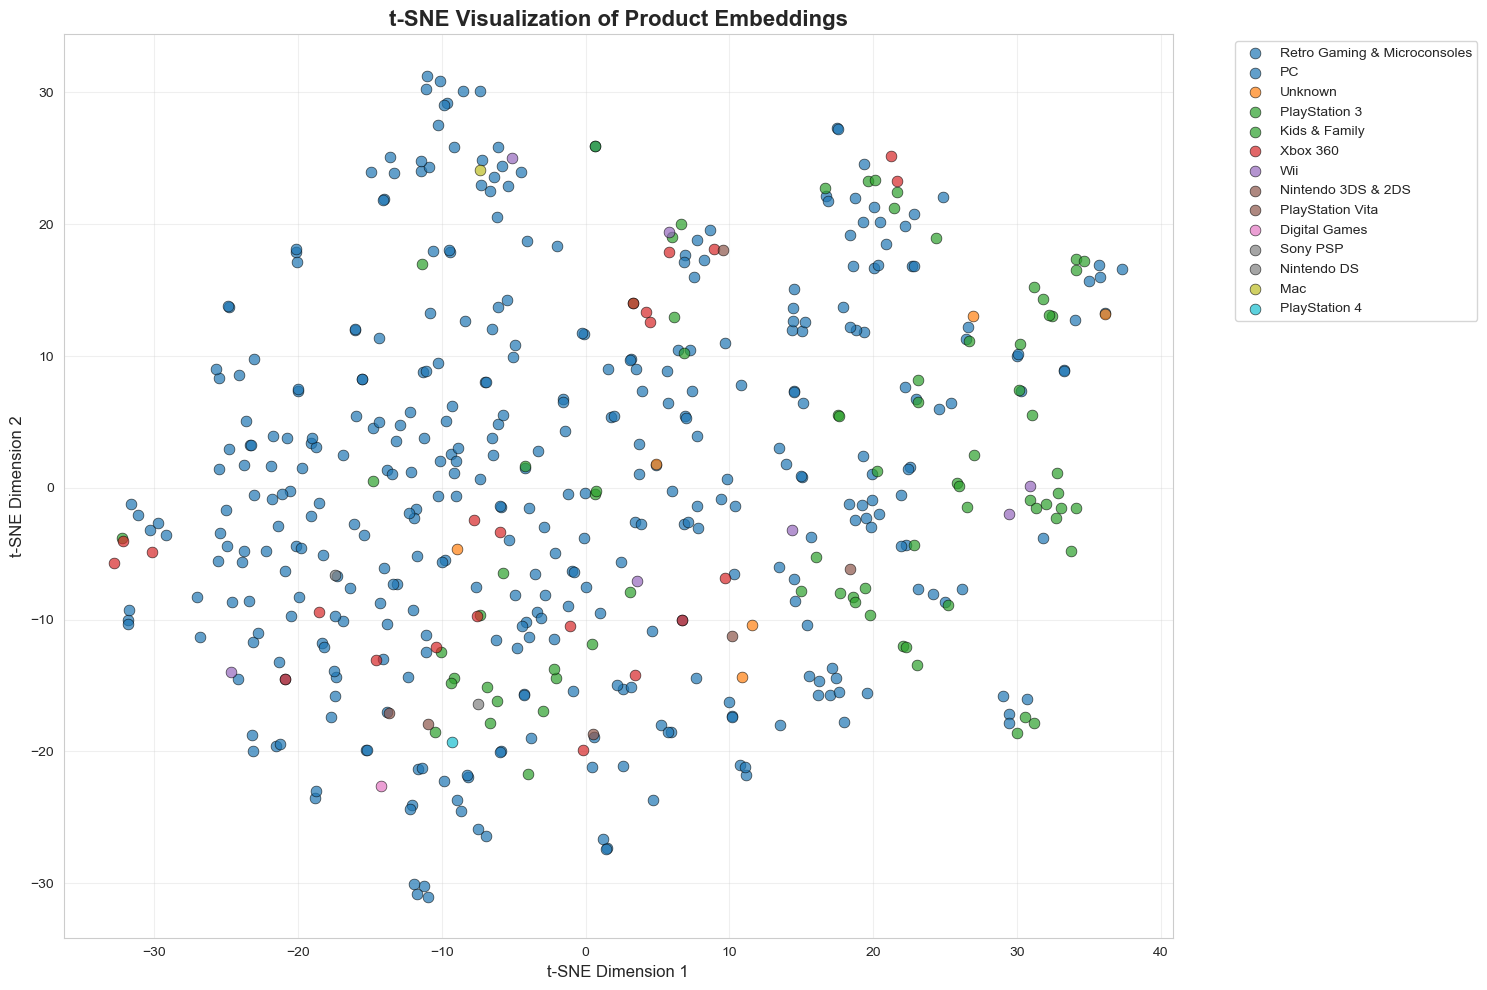

✅ Plotted 500 products across 14 categories
✅ Plot generation complete.


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# --- Step 1: Unpack all necessary variables from the main 'results' object ---
print("--- Step 1: Loading Variables ---")
# Make sure you have already run the main() function and have the 'pipeline_results' variable.
products_df = pipeline_results['products_df']
embeddings = pipeline_results['embeddings']
print(f"✅ 'products_df' loaded with {len(products_df)} rows.")
print(f"✅ 'embeddings' loaded with shape: {embeddings.shape}")
print("-" * 30)

# --- Step 2: Sample the data for plotting ---
print("--- Step 2: Sampling Data ---")
num_products_to_plot = 500
if len(products_df) > num_products_to_plot:
    sample_indices = np.random.choice(len(products_df), num_products_to_plot, replace=False)
else:
    sample_indices = np.arange(len(products_df))
sample_embeddings = embeddings[sample_indices]
sample_products_df = products_df.iloc[sample_indices]
print(f"✅ Sampled {len(sample_products_df)} products for plotting.")
print(f"✅ Shape of sample_embeddings: {sample_embeddings.shape}")
print("-" * 30)

# --- Step 3: Run the t-SNE algorithm ---
print("--- Step 3: Running t-SNE ---")
print("This may take a minute or two...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_embeddings)
print("✅ t-SNE calculation complete!")
print(f"✅ Shape of 2D embeddings: {embeddings_2d.shape}")
print("-" * 30)

# --- Step 4: Create DataFrame for Plotting ---
print("--- Step 4: Creating Plotting DataFrame ---")
# Make sure the 'secondary_cat' column exists. If not, you can use 'main_cat'.
tsne_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'title': sample_products_df['title'],
    'category': sample_products_df['secondary_cat'].fillna('Unknown')
})
print(f"✅ Plotting DataFrame created with {len(tsne_df)} rows.")
print("Here's a preview of the data being plotted:")
print(tsne_df.head())
print("-" * 30)

# --- Step 5: Create and Show the Plot using matplotlib ---
print("--- Step 5: Generating Plot with matplotlib ---")

# Create the plot using matplotlib
plt.figure(figsize=(15, 10))

# Get unique categories and assign colors
categories = tsne_df['category'].unique()

# Use a colormap to get distinct colors
cmap = cm.get_cmap('tab10')
colors = [cmap(i / len(categories)) for i in range(len(categories))]

# Plot each category with a different color
for i, category in enumerate(categories):
    mask = tsne_df['category'] == category
    category_data = tsne_df[mask]
    
    if len(category_data) > 0:
        plt.scatter(category_data['x'], category_data['y'], 
                   c=[colors[i]], label=category, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

plt.title('t-SNE Visualization of Product Embeddings', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Place legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Plotted {len(sample_indices)} products across {len(categories)} categories")
print("✅ Plot generation complete.")